# Using the xcube generator REST API

This notebook demonstrates direct use of the xcube generator REST API,
without the higher-level Python client library. It performs the following steps:

1. Use the xcube gen credentials to obtain an access token from the gen server.
2. Issue a gen server request to generate a cube and store it in an S3 bucket.
3. Monitor the status of the request until it has completed.
4. Open the newly generated cube from the S3 bucket and plot an image using its data.

This notebook reads the remote generator service configuration from the configuration file `edc_service.yml`, which may in turn contain references to environment variables. The notebook also requires the following environment variables to be set in order to write the generated cube into an S3 bucket:

```
AWS_ACCESS_KEY_ID
AWS_SECRET_ACCESS_KEY
```

First, import some necessary libraries.

In [1]:
import os
import requests
import time
import string
import yaml
from xcube.core.store import new_data_store

Set the endpoint URL, client ID, and client secret for the generator service, reading the values from the `edc_service.yml` configuration file.

In [2]:
with open('edc-service.yml', 'r') as fh:
    yaml_content = fh.read()
yaml_substituted = string.Template(yaml_content).safe_substitute(os.environ)
service_params = yaml.safe_load(yaml_substituted)

client_id = service_params['client_id']
client_secret = service_params['client_secret']
endpoint = service_params['endpoint_url']

Post a request to the generator's authorization service to get an access token authorized by the client credentials.

In [3]:
token_response = requests.post(
    endpoint + 'oauth/token',
    json = {
        'audience': endpoint,
        'client_id': client_id,
        'client_secret': client_secret,
        'grant_type': 'client-credentials',
    },
    headers = {'Accept': 'application/json'},
)

access_token = token_response.json()['access_token']

Create and issue a request to generate a cube containing soil moisture data for the European region. Note the use of the access token to authorize the request.

In [16]:
cubegen_request = {
    'input_config': {
        'store_id': '@cds',
        'data_id': 'satellite-soil-moisture:saturation:monthly',
        'open_params': {}
    },
    'cube_config': {
        'variable_names': ['soil_moisture_saturation'],
        'crs': 'WGS84',
        # 'bbox': [-13.00, 41.15, 21.79, 57.82],
        'spatial_res': 0.25,
        'time_range': ['2000-01-01', '2001-01-01'],
        'time_period': '1M',
        'chunks': {'lat': 65, 'lon': 139, 'time': 12},
    },
    'output_config': {
        'store_id': 's3',
        'data_id': 'cds-soil-moisture.zarr',
        'store_params': {'root': 'eurodatacube-scratch'},
        'replace': True,
    },
}

In [17]:
cubegen_response = requests.put(
    endpoint + 'cubegens',
    json=cubegen_request,
    headers={
        'Accept': 'application/json',
        'Authorization': 'Bearer ' + access_token
    },
)

Get the ID of the cube generation request so that we can monitor its progress.

In [18]:
cubegen_id = cubegen_response.json()['job_id']
cubegen_id

'a414f0ac6070db124b3999f70cc4790c5-9613a28d-d4ff-4317'

In [19]:
cubegen_response.json()

{'job_id': 'a414f0ac6070db124b3999f70cc4790c5-9613a28d-d4ff-4317',
 'job_result': {'output': [], 'status': 'ok', 'status_code': 200},
 'job_status': {'active': None,
  'completion_time': None,
  'conditions': None,
  'failed': None,
  'start_time': None,
  'succeeded': None}}

Check the request status repeatedly at five-second intervals until the request completes, then show the status.

In [21]:
while True:
    status_response = requests.get(
        endpoint + 'cubegens/' + cubegen_id,
        headers={
            'Accept': 'application/json',
            'Authorization': 'Bearer ' + access_token
        }
    )
    json_response = status_response.json()
    if json_response['job_status']['succeeded'] or json_response['job_status']['failed']:
        break
    time.sleep(5)

json_response['job_status']

{'active': None,
 'completion_time': '2021-09-15T14:05:35+00:00',
 'conditions': [{'last_probe_time': '2021-09-15T14:05:35+00:00',
   'last_transition_time': '2021-09-15T14:05:35+00:00',
   'message': None,
   'reason': None,
   'status': 'True',
   'type': 'Complete'}],
 'failed': None,
 'start_time': '2021-09-15T14:04:54+00:00',
 'succeeded': 1}

If the request was successful, the cube has now been written into an S3 bucket. Create an xcube data store to read the data from this bucket and list its contents.

In [13]:
data_store = new_data_store(
    's3',
    root='eurodatacube-scratch',
    storage_options={
        'key': os.environ['AWS_ACCESS_KEY_ID'],
        'secret': os.environ['AWS_SECRET_ACCESS_KEY']
    }
)

data_store.list_data_ids()

['COP_baltic_sea.zarr',
 'COP_black_sea.zarr',
 'COP_demo_v1.zarr',
 'COP_med_sea.zarr',
 'COP_med_sea_1.zarr',
 'S2L2A_B04_B05_7_53_9_55.zarr',
 'SH_demo.zarr',
 'cci-OC_chlor_a.zarr',
 'cds-soil-moisture.zarr',
 'cds-volumetric_surface_soil_moisture.zarr',
 'cop-services-LWQ_turbidity_mean.zarr',
 'cop-services-OC-ATL_CHL.zarr',
 'cube2.zarr',
 'my_mci_cube.zarr']

Open our newly-created dataset from this store and show a summary of its properties and contents.

In [14]:
dataset = data_store.open_data('cds-soil-moisture.zarr')
dataset

<xarray.Dataset>
Dimensions:     (time: 24, lat: 720, lon: 1440)
Coordinates:
  * lat         (lat) float32 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon         (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * time        (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2001-12-01
Data variables:
    freqbandID  (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs        (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sensor      (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sm          (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/42)
    Conventions:                CF-1.7
    cdm_data_type:              Grid
    comment:                    These data were produced as part of the Coper...
    contact:                    C3S_SM_Science@eodc.eu
    creator_email:              C3S_SM_Science@eodc.eu
    creator_name:               Earth Observation Data Center (EODC)
    ...                         ...
    time_coverage_duration:     P1M
    time_coverage_end:          2001-12-31T12:00:00Z
    time_coverage_resolution:   P1D
    time_coverage_start:        1999-12-31T12:00:00Z
    title:                      C3S Surface Soil Moisture merged ACTIVE Product
    tracking_id:                d6b32f68-8e46-44ea-9ed3-39de0a710356

Plot a map showing the generated data at a particular point in time.

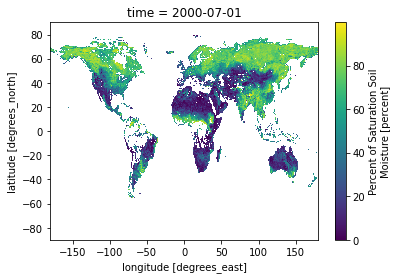

In [15]:
dataset.sm.isel(time=6).plot.imshow()